## Name : Vilohit Keshava Murthy Achar

## Student Id : 23077751

# GP Applied to the Even-Parity Problem

This time we apply GP to a Boolean problem -- this has a different type and different operators, but the algorithm remains the same.

The code in this notebook is a bit tighter, that is, although slightly more difficult to read, it is a lot more reusable. First of all, here's a nice piece of code to widen our notebook to make to easier to read the output we get later on.

Install DEAP.

In [1]:
!pip install deap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 2.1 MB/s eta 0:00:00


In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

Import our tools as before, except this time we also include **itertools** and **networks** which contain some nice iterative tools (for creating our test set) and graph drawing functionality, respectively.

In [3]:
import operator
import math
import random

import numpy

from deap import algorithms,base,creator,tools
from deap import gp


import matplotlib.pyplot as plt

import itertools
import networkx as nx



Set our Genetic Programming parameters.  Notice that these are virtually the same as the GA ones.

In [4]:
# Genetic Programming constants:
POPULATION_SIZE = 300
P_CROSSOVER = 0.9
P_MUTATION = 0.01
MAX_GENERATIONS = 100
HALL_OF_FAME_SIZE = 10


Set the random seed.

In [ ]:
RANDOM_SEED = 412
random.seed(RANDOM_SEED)

Here are some GP-specific constants. Keeping them together like this will make later editing easier.

In [ ]:
MIN_TREE_HEIGHT = 3
MAX_TREE_HEIGHT = 5
LIMIT_TREE_HEIGHT = 17
MUT_MIN_TREE_HEIGHT = 0
MUT_MAX_TREE_HEIGHT = 2

Some problem constants. One nice thing about this problem is that it is of scalable difficulty, so we name make it more difficult simply by increasing the number of inputs.

In [ ]:
NUM_INPUTS = 3
NUM_COMBINATIONS = 2 ** NUM_INPUTS

Here's our fitness function. This is a bit more involved than before as we first create all our test cases and then write a function to calculate the party error. We declare a wrapper function, **getCost** to make this code more resuable. This way we can change the fitness function and we only need to change the name in **getCost**.

In [ ]:
# calculate the truth table of even parity check:
parityIn = list(itertools.product([0, 1], repeat=NUM_INPUTS))
parityOut = []
for row in parityIn:
    parityOut.append(sum(row) % 2)

# calculate the difference between the results of the
# generated function and the expected parity results:
def parityError(individual):
    func = toolbox.compile(expr=individual)
    return sum(func(*pIn) != pOut for pIn, pOut in zip(parityIn, parityOut))

# fitness measure:
def getCost(individual):
    return parityError(individual), # return a tuple

Add our functions and terminals. This time we are using Boolean operators and values.

In [ ]:
# create the primitive set:
#First Function :
primitiveSet = gp.PrimitiveSet("main", NUM_INPUTS, "in_")
primitiveSet.addPrimitive(operator.and_, 2)
primitiveSet.addPrimitive(operator.or_, 2)
primitiveSet.addPrimitive(operator.xor, 2)
primitiveSet.addPrimitive(operator.not_, 1)

#Second Function:
arith_func_set = gp.PrimitiveSet("ARITHMETIC", NUM_INPUTS)
arith_func_set.addPrimitive(operator.add, 2)
arith_func_set.addPrimitive(operator.sub, 2)
arith_func_set.addPrimitive(operator.mul, 2)

#Third Function
trig_func_set = gp.PrimitiveSet("TRIGONOMETRIC", NUM_INPUTS)
trig_func_set.addPrimitive(numpy.sin, 1)
trig_func_set.addPrimitive(numpy.cos, 1)

# add terminal values:
primitiveSet.addTerminal(1)
primitiveSet.addTerminal(0)
arith_func_set.addTerminal(1)
arith_func_set.addTerminal(0)
trig_func_set.addTerminal(1)
trig_func_set.addTerminal(0)

Create our toolbox. This is very similar to the Symbolic Regression notebook except we are using the parameters declared up above.

In [ ]:
# Run the GP algorithm for different function sets
function_sets = [primitiveSet,arith_func_set,trig_func_set]
results = []
#maxFitnessValues = []
#meanFitnessValues = []
best_individual = []

for func_set in function_sets:

  toolbox = base.Toolbox()

  # define a single objective, minimizing fitness strategy:
  creator.create("FitnessMin", base.Fitness, weights=(-1.0,))

  # create the Individual class based on the primitive tree:
  creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)

  # create a helper function for creating random trees using the primitive set:
  toolbox.register("expr", gp.genFull, pset=func_set, min_=MIN_TREE_HEIGHT, max_=MAX_TREE_HEIGHT)

  # create the individual operator to fill up an Individual instance:
  toolbox.register("individualCreator", tools.initIterate, creator.Individual, toolbox.expr)

  # create the population operator to generate a list of individuals:
  toolbox.register("populationCreator", tools.initRepeat, list, toolbox.individualCreator)

  # create an operator to compile the primitive tree into python code:
  toolbox.register("compile", gp.compile, pset=func_set)

  toolbox.register("evaluate", getCost)

  # genetic operators:
  toolbox.register("select", tools.selTournament, tournsize=2)
  toolbox.register("mate", gp.cxOnePoint)
  toolbox.register("expr_mut", gp.genGrow, min_=MUT_MIN_TREE_HEIGHT, max_=MUT_MAX_TREE_HEIGHT)
  toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=func_set)

  # bloat control:
  toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=LIMIT_TREE_HEIGHT))
  toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=LIMIT_TREE_HEIGHT))

  #Set up our population as before

  population = toolbox.populationCreator(n=POPULATION_SIZE)
  # define the hall-of-fame object:
  hof = tools.HallOfFame(HALL_OF_FAME_SIZE)

  #Create a statistics object. This time we're going to use the MultiStatistics tool because we want to record statistics about size as well as fitness.

  stats_fit = tools.Statistics(lambda ind: ind.fitness.values)
  stats_size = tools.Statistics(len)
  mstats = tools.MultiStatistics(fitness=stats_fit, size=stats_size)
  mstats.register("avg", numpy.mean)
  mstats.register("std", numpy.std)
  mstats.register("min", numpy.min)
  mstats.register("max", numpy.max)

  #Run our GP. Notice how much slower this one is, due to the much larger population size.

  population, logbook = algorithms.eaSimple(population,
                                                  toolbox,
                                                  cxpb=P_CROSSOVER,
                                                  mutpb=P_MUTATION,
                                                  ngen=MAX_GENERATIONS,
                                                  stats=mstats,
                                                  halloffame=hof,
                                                  verbose=True)

  best = hof.items[0]
  print("best ::: ", best)
  print("hof.items[0] :::: ", hof.items[0])
  #maxFitnessValues.append(logbook.chapters['fitness'].select("min"))
  #meanFitnessValues.append(logbook.chapters['fitness'].select("avg"))
  maxFitnessValues, meanFitnessValues = logbook.chapters['fitness'].select("min", "avg")

  results.append((func_set.name, best,maxFitnessValues,meanFitnessValues ))
  best_individual.append(hof.items[0])


  print(results)
  #print(best_individual)
  #print(maxFitnessValues)
  #print(meanFitnessValues)




   	      	                    fitness                     	                      size                     
   	      	------------------------------------------------	-----------------------------------------------
gen	nevals	avg    	gen	max	min	nevals	std     	avg    	gen	max	min	nevals	std    
0  	300   	3.97333	0  	6  	1  	300   	0.599407	21.4767	0  	58 	4  	300   	12.5901
1  	276   	3.86667	1  	8  	1  	276   	0.63421 	20.9967	1  	75 	2  	276   	12.9227
2  	276   	3.87667	2  	6  	2  	276   	0.622995	21.3867	2  	80 	2  	276   	12.8876
3  	276   	3.73333	3  	6  	0  	276   	0.74087 	23.1167	3  	82 	2  	276   	12.9788
4  	258   	3.66667	4  	6  	1  	258   	0.679869	24.9967	4  	58 	2  	258   	13.7677
5  	268   	3.62333	5  	6  	1  	268   	0.779822	26.2233	5  	69 	2  	268   	14.1245
6  	278   	3.46667	6  	8  	0  	278   	0.899383	26.79  	6  	69 	2  	278   	13.4905
7  	263   	3.28   	7  	6  	1  	263   	0.89159 	27.3567	7  	72 	2  	263   	14.8953
8  	266   	3.2    	8  	6  	0  	266   	1.05198 

--- Function Name =  main
-- Best Individual =  or_(or_(and_(or_(not_(in_0), or_(in_1, xor(0, in_2))), xor(not_(0), 1)), xor(or_(in_2, 0), xor(in_0, in_1))), not_(or_(not_(not_(or_(xor(and_(in_1, 1), and_(in_1, 0)), or_(xor(in_2, in_0), or_(or_(1, in_0), and_(in_1, in_0)))))), and_(not_(in_1), not_(1)))))
-- length=50, height=9
-- Best Fitness =  0.0
--- Function Name =  ARITHMETIC
-- Best Individual =  sub(mul(mul(mul(ARG2, sub(sub(ARG1, mul(add(ARG0, ARG1), mul(ARG1, sub(0, add(sub(mul(ARG1, mul(mul(0, ARG0), mul(ARG2, ARG2))), ARG2), sub(mul(ARG1, ARG0), ARG0)))))), mul(sub(ARG2, mul(mul(mul(mul(ARG2, 1), 0), ARG0), mul(mul(0, 0), ARG0))), 1))), mul(mul(0, sub(sub(ARG1, ARG2), add(ARG0, 0))), sub(ARG1, mul(mul(add(ARG0, sub(ARG1, ARG2)), mul(0, mul(mul(0, 0), sub(mul(mul(mul(ARG0, 0), sub(ARG0, 0)), sub(1, sub(0, ARG2))), ARG1)))), sub(ARG2, ARG1))))), sub(mul(mul(0, 0), mul(mul(0, mul(mul(ARG1, mul(mul(mul(sub(ARG1, ARG1), sub(1, sub(ARG1, ARG2))), mul(mul(0, ARG1), sub(ARG1, mul(a

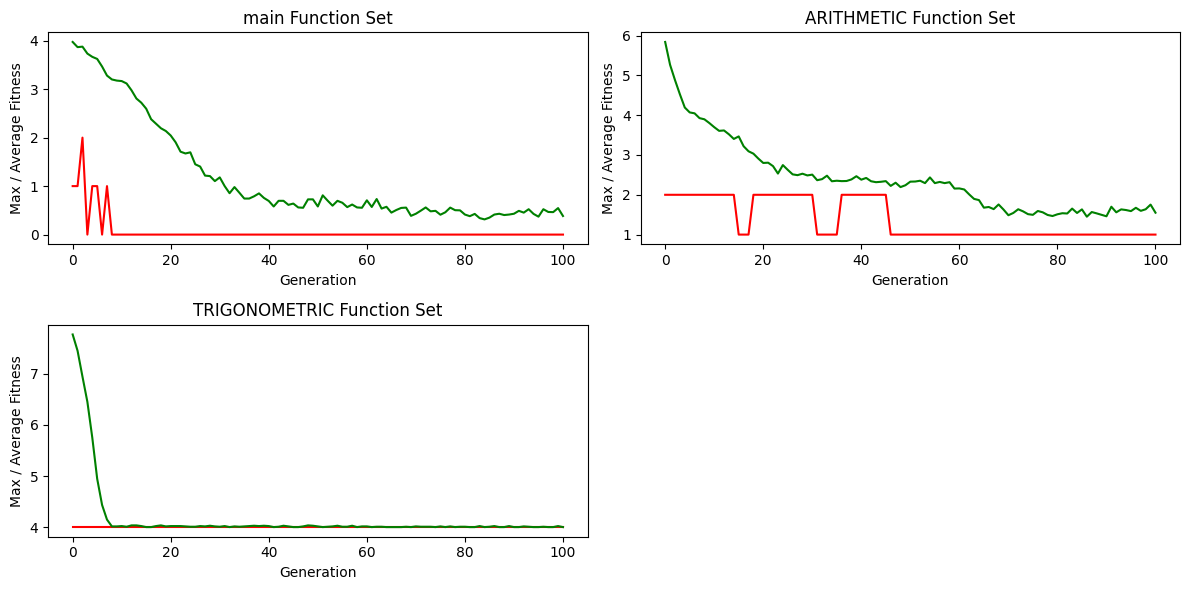

In [ ]:
# Visualize the results

plt.figure(figsize=(12, 6))
for i, (func_set_name, best_ind, maxFitnessValues,meanFitnessValues) in enumerate(results):
    plt.subplot(2, 2, i+1)
    print("--- Function Name = ",func_set_name)
    print("-- Best Individual = ", best_ind)
    print("-- length={}, height={}".format(len(best_ind), best_ind.height))
    print("-- Best Fitness = ", best_ind.fitness.values[0])
    plt.plot(maxFitnessValues, color='red')
    plt.plot(meanFitnessValues, color='green')
    plt.title(f"{func_set_name} Function Set")
    plt.xlabel("Generation")
    plt.ylabel("Max / Average Fitness")

plt.tight_layout()
plt.show()